# ODR - Code Examples

## General Investigation of ODR

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import ODR, Model, RealData
import scipy.stats as stats
import seaborn as sns

In [2]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """
    A, B = beta
    return A * (np.exp(-B * x) - 1) + 100

In [3]:
# Dataset 3
x = np.array([0, 23, 51, 98, 196, 292, 401])
y_obs = np.array([100, 87.8, 77, 65.7, 50.9, 46.5, 44.4])
sigma_x = np.full_like(x, 2.0, dtype=float)
sigma_y = np.full_like(y_obs, 0.5, dtype=float)
initial_guess = [50, 0.01]

results = {}

In [4]:
# Define the ODR model and data
odr_model = Model(model_function)
odr_data = RealData(x, y_obs, sx=sigma_x, sy=sigma_y)

# Instantiate and run the ODR fit
odr_instance = ODR(odr_data, odr_model, beta0=initial_guess)
output = odr_instance.run()

In [5]:
output.pprint()

Beta: [5.67694275e+01 9.88335260e-03]
Beta Std Error: [4.26741666e-01 2.63972932e-04]
Beta Covariance: [[ 2.41744445e-01 -1.18588964e-04]
 [-1.18588964e-04  9.25007382e-08]]
Residual Variance: 0.7533097575791786
Inverse Condition #: 0.17698951436366908
Reason(s) for Halting:
  Sum of squares convergence


### Inverse Condition Number

The "Inverse Condition #" is the reciprocal (1/x) of the condition number. The condition number itself is a measure of how sensitive the solution (the estimated parameters of your model) is to changes in the input data.

*   **A large Inverse Condition Number (close to 1)** indicates a well-conditioned problem. This is desirable and suggests that small changes in your input data will only cause small changes in the estimated parameters.
    * Our result of approximately 0.177 is in a moderate range - it's not ideal (e.g., >0.5 would be better for high precision), but it's far from problematic levels (e.g., <0.01), especially for a small dataset like ours. No major numerical instability is indicated here, and the fit should be reliable for practical purposes (for practical purposes, as long as inverse condition number isn't extremely close to zero, it's generally acceptable).

*   **A small Inverse Condition Number (close to 0)** points to an ill-conditioned problem. In such cases, minor variations in the input data could lead to significant changes in the determined parameters, making the solution less reliable.

In essence, this number helps you gauge the numerical stability and reliability of the parameter estimates provided by the Orthogonal Distance Regression (ODR) fit.

### Reason(s) for Halting: Sum of Squares Convergence

This indicates why the iterative fitting process stopped. The ODR algorithm works by iteratively adjusting the parameters (`A` and `B` in your model) to minimize the sum of the squared weighted orthogonal distances from the data points to the fitted curve.

"Sum of squares convergence" means that the algorithm terminated because the improvements in the sum of squared residuals from one iteration to the next became negligibly small. This is a standard and successful stopping criterion for such optimization routines. It implies that the algorithm has found a stable solution where further adjustments to the parameters do not significantly improve the fit to the data.

In [6]:
fit_params = output.beta
print(f"Fitted parameters (output.beta): {fit_params}")

sd_beta = output.sd_beta
print(f"Standard deviations of the parameters (output.sd_beta): {sd_beta}")

sd_beta_2 = np.sqrt(np.diag(output.cov_beta * output.res_var))
print(f"Standard deviations of the parameters (alternative calculation using cov_beta): {sd_beta_2}")

inv_cond_num = output.inv_condnum
print(f"Inverse condition number (output.inv_condnum): {inv_cond_num}")


Fitted parameters (output.beta): [5.67694275e+01 9.88335260e-03]
Standard deviations of the parameters (output.sd_beta): [4.26741666e-01 2.63972932e-04]
Standard deviations of the parameters (alternative calculation using cov_beta): [4.26741666e-01 2.63972932e-04]
Inverse condition number (output.inv_condnum): 0.17698951436366908


In [7]:
# Store the original data in the results dictionary for plotting later
results['original_x'] = x
results['original_y'] = y_obs
results['original_sigma_x'] = sigma_x
results['original_sigma_y'] = sigma_y
results['original_weights_x'] = 1.0 / (sigma_x**2)
results['original_weights_y'] = 1.0 / (sigma_y**2)

# Store results from ODR's Output object
results['odr_output'] = output
results['fit_params'] = output.beta
results['std_errs'] = output.sd_beta
results['cov_beta'] = output.cov_beta
results['number_of_observations'] = len(x)
results['number_of_parameters'] = len(output.beta)
results['degrees_of_freedom'] = results['number_of_observations'] - results['number_of_parameters']
results['inverse_condition_number'] = output.inv_condnum

In [8]:
t_values = results['fit_params'] / results['std_errs']
p_values = stats.t.sf(np.abs(t_values), df=results['degrees_of_freedom']) * 2
results['t_values'] = t_values
results['p_values'] = p_values
print(f"t-values: {t_values}")
print(f"p-values: {p_values}")


t-values: [133.02996178  37.44078054]
p-values: [4.55295786e-10 2.56015184e-07]


In [9]:
delta_x = output.delta
results['delta_x'] = delta_x
print(f"Array of estimated errors in input variables, of same shape as x (output.delta):\n{delta_x}")

epsilon_y = output.eps
results['epsilon_y'] = epsilon_y
print(f"Array of estimated errors in response variables, of same shape as y (output.eps):\n{epsilon_y}")

Array of estimated errors in input variables, of same shape as x (output.delta):
[ 0.          1.12128483  1.00051757 -1.82517415  0.59658578 -0.05011438
 -0.01544762]
Array of estimated errors in response variables, of same shape as y (output.eps):
[ 0.          0.15853071  0.18633185 -0.52598787  0.46385468 -0.09998956
 -0.09054455]


In [10]:
x_pred = output.xplus
results['x_pred'] = output.xplus
print(f"Array of predicted x values (output.xplus):\n{x_pred}")

x_pred_2 = x + output.delta
print(f"Array of predicted x values (x + output.delta):\n{x_pred_2}")

y_pred = output.y
results['y_pred'] = output.y
print(f"\nArray of predicted y values (output.y):\n{y_pred}")

y_pred_2 = model_function(results['fit_params'], x + delta_x)
print(f"Array of predicted y values (model_function with (x + delta_x) argument):\n{y_pred_2}")

Array of predicted x values (output.xplus):
[  0.          24.12128483  52.00051757  96.17482585 196.59658578
 291.94988562 400.98455238]
Array of predicted x values (x + output.delta):
[  0.          24.12128483  52.00051757  96.17482585 196.59658578
 291.94988562 400.98455238]

Array of predicted y values (output.y):
[100.          87.95853071  77.18633185  65.17401213  51.36385468
  46.40001044  44.30945545]
Array of predicted y values (model_function with (x + delta_x) argument):
[100.          87.95853071  77.18633185  65.17401213  51.36385468
  46.40001044  44.30945545]


### Predicted values of x and y

- `output.xplus` represents the "predicted" or adjusted x-values. These are computed as the original `x` plus the estimated errors/adjustments in the input variables (`output.delta`), i.e., `xplus = x + delta`. They correspond to the x-coordinates on the fitted curve that are closest (in an orthogonal sense) to each observed data point `(x[i], y_obs[i])`.

- `output.y` represents the predicted y-values, which are the model's evaluations at those adjusted x-values: `y = model_function(beta, xplus)`. These are the y-coordinates on the fitted curve corresponding to the same closest points.

Together, the pairs `(output.xplus[i], output.y[i])` are the projections (feet of the perpendiculars) of our observed data points onto the fitted curve. This differs from ordinary least squares regression (where errors are assumed only in y, and predictions are simply `model_function(beta, x)` at the original x-values). In ODR, since errors are considered in both x and y, these adjusted predictions account for uncertainties in both directions, minimizing the orthogonal distances.

Our code already demonstrates this equivalence with the alternative calculations:
- `x_pred_2 = x + output.delta` matches `output.xplus`.
- `y_pred_2 = model_function(fit_params, x + delta_x)` matches `output.y`.

In [11]:
sum_square_delta = output.sum_square_delta
print(f"Sum of squares of delta error (output.sum_square_delta): {sum_square_delta:.4f}")

delta_errors = output.delta
manual_sum_square_delta = np.sum((delta_errors / sigma_x)**2)
print(f"Manually calculated sum_square_delta: {manual_sum_square_delta:.4f}")

sum_square_eps = output.sum_square_eps
print(f"\nSum of squares of epsilon error (output.sum_square_eps): {sum_square_eps:.4f}")

epsilon_errors = output.eps
manual_sum_square_eps = np.sum((epsilon_errors / sigma_y)**2)
print(f"Manually calculated sum_square_eps: {manual_sum_square_eps:.4f}")

Sum of squares of delta error (output.sum_square_delta): 1.4871
Manually calculated sum_square_delta: 1.4871

Sum of squares of epsilon error (output.sum_square_eps): 2.2795
Manually calculated sum_square_eps: 2.2795


In [12]:
sum_square = output.sum_square
results['chi_squared_odr'] = output.sum_square
print(f"Chi-squared (output.sum_square): {sum_square:.4f}")

res_var = output.res_var
results['reduced_chi_squared_odr'] = output.res_var
print(f"Reduced Chi-squared (output.res_var): {res_var:.4f}")

# Calculate Chi-Squared manually as per the formula
# ODR output provides delta (residuals in x) and eps (residuals in y)
chi_squared_manual = np.sum((output.delta / sigma_x)**2 + (output.eps / sigma_y)**2)
results['chi_squared_manual'] = chi_squared_manual
print(f"Chi-squared (manual calculation): {chi_squared_manual:.4f}")

# Reduced Chi-Squared (manual calculation)
reduced_chi_squared_manual = chi_squared_manual / results['degrees_of_freedom']
results['reduced_chi_squared_manual'] = reduced_chi_squared_manual
print(f"Reduced Chi-squared (manual calculation): {reduced_chi_squared_manual:.4f}")

Chi-squared (output.sum_square): 3.7665
Reduced Chi-squared (output.res_var): 0.7533
Chi-squared (manual calculation): 3.7665
Reduced Chi-squared (manual calculation): 0.7533


In [14]:
# Information Criteria (using the log-likelihood for ODR, which is implicitly
# based on the chi-squared statistic, assuming a Gaussian error model).
n = results['number_of_observations']
p = results['number_of_parameters']

# A simplified log-likelihood for ODR, based on the chi-squared value.
# This is a good approximation for comparison purposes.
llf = - n * np.log(2 * np.pi) - np.sum(np.log(sigma_x)) - np.sum(np.log(sigma_y)) - 0.5 * results['chi_squared_odr']

aic = -2 * llf + 2 * p
bic = -2 * llf + np.log(n) * p
aicc = aic + (2 * p * (p + 1)) / (n - p - 1)

results['log_likelihood'] = llf
results['aic'] = aic
results['bic'] = bic
results['aicc'] = aicc

print('Maximum Log-Likelihood:', llf)
print('AIC:', aic)
print('BIC:', bic)
print('AICC:', aicc)

Maximum Log-Likelihood: -14.748413858813365
AIC: 33.49682771762673
BIC: 33.38864801573735
AICC: 36.49682771762673


## General Methods for ODR Analysis

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import ODR, Model, RealData
import scipy.stats as stats
import seaborn as sns

In [ ]:
def analyze_odr(x, y_obs, sigma_x, sigma_y, function, initial_guess):
    """
    Performs an Orthogonal Distance Regression (ODR) curve fit and calculates
    various goodness-of-fit and error metrics.

    Args:
        x (np.array): The independent variable data.
        y_obs (np.array): The observed dependent variable data.
        sigma_x (np.array): The standard deviations of the x points.
        sigma_y (np.array): The standard deviations of the y_obs points.
        function (callable): The function to fit to the data.
        initial_guess (list): The initial guess for the function parameters.

    Returns:
        dict: A dictionary containing all the calculated results.
    """
    results = {}

    # Define the ODR model and data
    odr_model = Model(function)
    odr_data = RealData(x, y_obs, sx=sigma_x, sy=sigma_y)

    # Instantiate and run the ODR fit
    odr_instance = ODR(odr_data, odr_model, beta0=initial_guess)
    output = odr_instance.run()

    # Store the original data in the results dictionary for plotting later
    results['original_x'] = x
    results['original_y'] = y_obs
    results['original_sigma_x'] = sigma_x
    results['original_sigma_y'] = sigma_y
    results['original_weights_x'] = 1.0 / (sigma_x**2)
    results['original_weights_y'] = 1.0 / (sigma_y**2)
    
    # Store results from ODR's Output object
    results['odr_output'] = output
    results['fit_params'] = output.beta
    results['std_errs'] = output.sd_beta
    results['cov_beta'] = output.cov_beta
    results['number_of_observations'] = len(x)
    results['number_of_parameters'] = len(output.beta)
    results['degrees_of_freedom'] = results['number_of_observations'] - results['number_of_parameters']
    results['inverse_condition_number'] = output.inv_condnum

    # Calculate t-values and p-values
    t_values = results['fit_params'] / results['std_errs']
    p_values = stats.t.sf(np.abs(t_values), df=results['degrees_of_freedom']) * 2
    results['t_values'] = t_values
    results['p_values'] = p_values

    # Chi-Squared and Reduced Chi-Squared from ODR output
    results['chi_squared_odr'] = output.sum_square
    results['reduced_chi_squared_odr'] = output.res_var

    # Calculate Chi-Squared manually as per the formula
    # ODR output provides delta (residuals in x) and eps (residuals in y)
    delta_x = output.delta
    epsilon_y = output.eps
    
    chi_squared_manual = np.sum((delta_x / sigma_x)**2 + (epsilon_y / sigma_y)**2)
    results['chi_squared_manual'] = chi_squared_manual

    # Reduced Chi-Squared (manual calculation)
    reduced_chi_squared_manual = chi_squared_manual / results['degrees_of_freedom']
    results['reduced_chi_squared_manual'] = reduced_chi_squared_manual

    # Generate predicted values
    y_pred = function(results['fit_params'], x + delta_x) #????
    results['y_pred'] = y_pred
    
    # Unweighted residuals for unweighted metrics
    unweighted_residuals = y_obs - y_pred
    results['unweighted_residuals'] = unweighted_residuals
    
    # Sum of Squares and R-squared metrics
    rss_unweighted = np.sum(unweighted_residuals**2)
    unweighted_centered_tss = np.sum((y_obs - np.mean(y_obs))**2)
    r_squared_unweighted = 1 - rss_unweighted / unweighted_centered_tss
    results['r_squared_unweighted'] = r_squared_unweighted

    # Note: ODR does not have a concept of weighted R-squared as standard curve_fit.
    # The goodness-of-fit is primarily assessed by the reduced chi-squared.

    # Information Criteria (using the log-likelihood for ODR, which is implicitly
    # based on the chi-squared statistic, assuming a Gaussian error model).
    n = results['number_of_observations']
    p = results['number_of_parameters']
    
    # A simplified log-likelihood for ODR, based on the chi-squared value.
    # This is a good approximation for comparison purposes.
    llf = -0.5 * results['chi_squared_manual'] - n/2 * np.log(2*np.pi) - np.sum(np.log(sigma_x)) - np.sum(np.log(sigma_y))
    
    aic = -2 * llf + 2 * p
    bic = -2 * llf + np.log(n) * p
    aicc = aic + (2 * p * (p + 1)) / (n - p - 1)

    results['log_likelihood'] = llf
    results['aic'] = aic
    results['bic'] = bic
    results['aicc'] = aicc

    return results

In [8]:
def print_metrics(results):
    """
    Prints the calculated metrics from the results dictionary for ODR.
    """
    output = results['odr_output']
    fit_params = results['fit_params']
    std_errs = results['std_errs']
    t_values = results['t_values']
    p_values = results['p_values']
    n = results['number_of_observations']
    p = results['number_of_parameters']

    print("--- ODR Fit Results ---")
    output.pprint()
    
    print("\n--- Summary of Results ---")
    for i, (param, err) in enumerate(zip(fit_params, std_errs)):
        print(f"Parameter {chr(ord('A') + i)}: {param:.5f} +/- {err:.5f}")
        print(f"  T-value: {t_values[i]:.8f}, P-value: {p_values[i]:.8f}")

    print("\n--- Model Fit Statistics ---")
    print(f"\nNumber of Observations (n): {n}")
    print(f"Number of Parameters (p): {p}")
    print(f"Degrees of Freedom (n-p): {results['degrees_of_freedom']}")

    print("\n--- Goodness-of-Fit & Error Metrics ---")
    print(f"Chi-Squared (from ODR): {results['chi_squared_odr']:.4f}")
    print(f"Chi-Squared (manual): {results['chi_squared_manual']:.4f}")
    print(f"Reduced Chi-Squared (from ODR): {results['reduced_chi_squared_odr']:.4f}")
    print(f"Reduced Chi-Squared (manual): {results['reduced_chi_squared_manual']:.4f}")
    print(f"Unweighted R-squared: {results['r_squared_unweighted']:.4f}")
    
    print("\n--- Information Criteria ---")
    print(f"Maximum Log-Likelihood: {results['log_likelihood']:.4f}")
    print(f"AIC (Akaike Information Criterion): {results['aic']:.4f}")
    print(f"BIC (Bayesian Information Criterion): {results['bic']:.4f}")
    print(f"AICc (Corrected AIC): {results['aicc']:.4f}")

In [9]:
def draw_curve_fit(results, model_function):
    """
    Visualizes the original data with error bars and the fitted curve from ODR.
    """
    plt.figure(figsize=(8, 6))
    sns.set_theme(style="whitegrid")

    # Access the original data from the results dictionary
    x_data = results["original_x"]
    y_data = results["original_y"]
    sigma_x = results["original_sigma_x"]
    sigma_y = results["original_sigma_y"]
    popt = results['fit_params']
    perr = results['std_errs']
    
    # Plot data with error bars for both x and y
    plt.errorbar(x_data, y_data, xerr=sigma_x, yerr=sigma_y, fmt='o', label="Original Data", color='blue', zorder=5)

    # Generate points for the fitted curve
    x_plot = np.linspace(min(x_data), max(x_data) * 1.05, 500)
    y_plot = model_function(popt, x_plot)
    
    label_text = f"Fitted Curve\n"
    if len(popt) > 0:
        label_text += f"A={popt[0]:.3f}±{perr[0]:.3f}\n"
    if len(popt) > 1:
        label_text += f"B={popt[1]:.5f}±{perr[1]:.5f}"

    sns.lineplot(x=x_plot, y=y_plot, color='red', label=label_text.strip())

    # Create a dynamic title with key metrics
    title = (
        f"Unweighted $R^2$={results['r_squared_unweighted']:.4f}\n"
        f"Reduced $\\chi^2$ (ODR)={results['reduced_chi_squared_odr']:.4f}"
    )

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.xlim(xmin=min(x_data) - 5)
    plt.ylim(ymin=min(y_data) - 10, ymax=max(y_data) + 10)
    plt.tight_layout()
    plt.show()

--- ODR Fit Results ---
Beta: [5.67694275e+01 9.88335260e-03]
Beta Std Error: [4.26741666e-01 2.63972932e-04]
Beta Covariance: [[ 2.41744445e-01 -1.18588964e-04]
 [-1.18588964e-04  9.25007382e-08]]
Residual Variance: 0.7533097575791786
Inverse Condition #: 0.17698951436366908
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 56.76943 +/- 0.42674
  T-value: 133.02996178, P-value: 0.00000000
Parameter B: 0.00988 +/- 0.00026
  T-value: 37.44078054, P-value: 0.00000026

--- Model Fit Statistics ---

Number of Observations (n): 7
Number of Parameters (p): 2
Degrees of Freedom (n-p): 5

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 3.7665
Chi-Squared (manual): 3.7665
Reduced Chi-Squared (from ODR): 0.7533
Reduced Chi-Squared (manual): 0.7533
Unweighted R-squared: 0.9998

--- Information Criteria ---
Maximum Log-Likelihood: -8.3158
AIC (Akaike Information Criterion): 20.6317
BIC (Bayesian Information Criterion): 20.5235
AICc (Correc

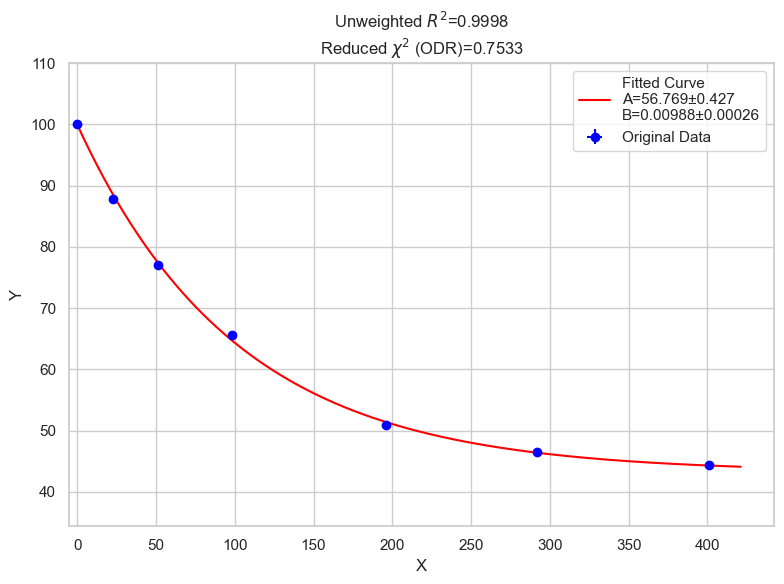

In [ ]:

def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """
    A, B = beta
    return A * (np.exp(-B * x) - 1) + 100

# Dataset 3
x = np.array([0, 23, 51, 98, 196, 292, 401])
y_obs = np.array([100, 87.8, 77, 65.7, 50.9, 46.5, 44.4])
sigma_y = np.full_like(y_obs, 0.5, dtype=float)
sigma_x = np.full_like(x, 2.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit(odr_results, model_function)


In [11]:
odr_results['odr_output'].pprint()

Beta: [5.67694275e+01 9.88335260e-03]
Beta Std Error: [4.26741666e-01 2.63972932e-04]
Beta Covariance: [[ 2.41744445e-01 -1.18588964e-04]
 [-1.18588964e-04  9.25007382e-08]]
Residual Variance: 0.7533097575791786
Inverse Condition #: 0.17698951436366908
Reason(s) for Halting:
  Sum of squares convergence


## Code 2

--- ODR Fit Results ---
Beta: [5.64837483e+01 3.34000206e-02]
Beta Std Error: [1.85220408 0.00404159]
Beta Covariance: [[ 1.37387692e+00 -2.48458954e-03]
 [-2.48458954e-03  6.54144342e-06]]
Residual Variance: 2.497064990325722
Inverse Condition #: 0.04982581594705908
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 56.48375 +/- 1.85220
  T-value: 30.49542373, P-value: 0.00000071
Parameter B: 0.03340 +/- 0.00404
  T-value: 8.26408960, P-value: 0.00042316

--- Model Fit Statistics ---

Number of Observations (n): 7
Number of Parameters (p): 2
Degrees of Freedom (n-p): 5

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 12.4853
Chi-Squared (manual): 12.4853
Reduced Chi-Squared (from ODR): 2.4971
Reduced Chi-Squared (manual): 2.4971
Unweighted R-squared: 1.0000

--- Information Criteria ---
Maximum Log-Likelihood: -12.6752
AIC (Akaike Information Criterion): 29.3505
BIC (Bayesian Information Criterion): 29.2423
AICc (Corrected AIC)

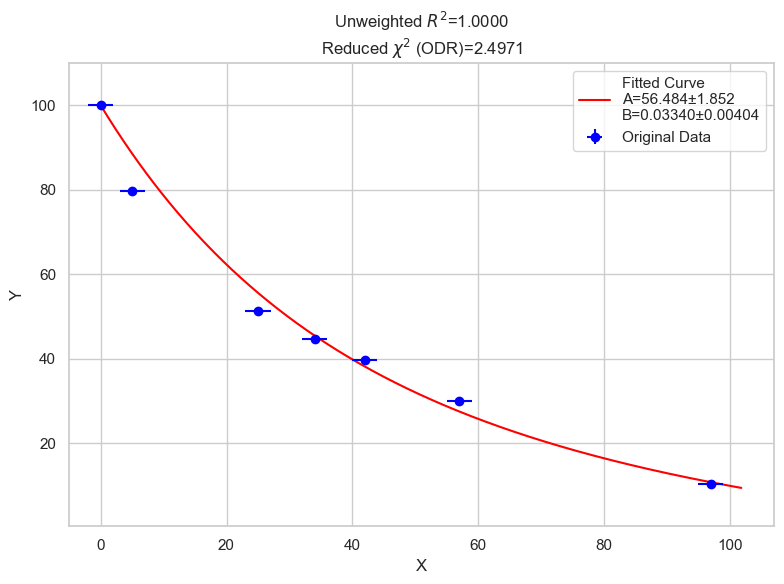

In [12]:
## Dataset 3. Comparison
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """

    A_1 = 56.769
    B_1 = 0.00988

    A, B = beta
    
    return A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100

# Dataset 3
x = np.array([0, 5, 25, 34, 42, 57, 97])
y_obs = np.array([100, 79.7, 51.3, 44.6, 39.8, 29.9, 10.3])
sigma_y = np.full_like(y_obs, 0.5, dtype=float)
sigma_x = np.full_like(x, 2.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit(odr_results, model_function)

## Code 3

--- Fitted Parameters (from ODR) ---
Parameter A: 56.76943 +/- 0.42674
  T-value: 133.02996178, P-value: 0.00000000
Parameter B: 0.00988 +/- 0.00026
  T-value: 37.44078054, P-value: 0.00000026

--- Model Fit Statistics ---
Number of Observations (n): 7
Number of Parameters (p): 2
Degrees of Freedom (n-p): 5

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 3.7665
Reduced Chi-Squared (from ODR): 0.7533
Chi-Squared (manual): 3.7665
Reduced Chi-Squared (manual): 0.7533
Unweighted R-squared: 0.9993
Unweighted Adjusted R-squared: 0.9992
Unweighted RMSE: 0.5113
Unweighted SER: 0.6049

--- Sum of Squares ---
Unweighted Residual Sum of Squares (RSS): 1.8298
Unweighted Explained Sum of Squares (ESS): 2845.2469
Unweighted Centered Total Sum of Squares (TSS): 2811.9943

--- Information Criteria ---
Log-Likelihood: -1.8833
AIC (Akaike Information Criterion): 7.7665
BIC (Bayesian Information Criterion): 7.6584
AICc (Corrected AIC): 10.7665

--- ODR Output Details ---
Beta: [5.6769427

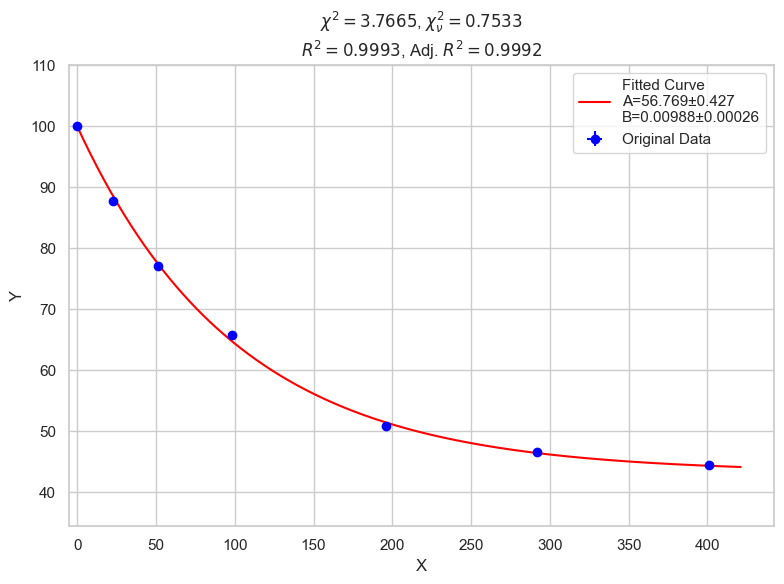

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import ODR, Model, RealData
import seaborn as sns
import scipy.stats as stats

def analyze_odr_fit(x, y_obs, sigma_x, sigma_y, function, initial_guess):
    """
    Performs an Orthogonal Distance Regression (ODR) fit and calculates
    various goodness-of-fit and error metrics.

    Args:
        x (np.array): The independent variable data.
        y_obs (np.array): The observed dependent variable data.
        sigma_x (np.array): The standard deviations of the x points.
        sigma_y (np.array): The standard deviations of the y_obs points.
        function (callable): The function to fit to the data.
        initial_guess (list): The initial guess for the function parameters.

    Returns:
        dict: A dictionary containing all the calculated results.
    """
    results = {}

    # Define the model for ODR
    def odr_function(p, x):
        return function(x, *p)

    model = Model(odr_function)
    data = RealData(x, y_obs, sx=sigma_x, sy=sigma_y)
    odr = ODR(data, model, beta0=initial_guess)
    odr_output = odr.run()

    results['x_data'] = x
    results['y_data'] = y_obs
    results['sigma_x'] = sigma_x
    results['sigma_y'] = sigma_y
    results['weights_x'] = 1.0 / (sigma_x**2)
    results['weights_y'] = 1.0 / (sigma_y**2)

    # --- ODR Output ---
    popt = odr_output.beta
    pcov = odr_output.cov_beta
    perr = odr_output.sd_beta
    
    results['popt'] = popt
    results['pcov'] = pcov
    results['std_errs'] = perr
    results['output'] = odr_output

    # --- Parameter Statistics ---
    n = len(x)
    p = len(popt)
    degrees_of_freedom = n - p

    t_values = popt / perr
    p_values = stats.t.sf(np.abs(t_values), df=degrees_of_freedom) * 2

    results['fit_params'] = popt
    results['t_values'] = t_values
    results['p_values'] = p_values
    results['number_of_observations'] = n
    results['number_of_parameters'] = p
    results['degrees_of_freedom'] = degrees_of_freedom
    results['condition_number'] = odr_output.inv_condnum

    # --- Fitted values and Residuals ---
    x_fit = odr_output.xplus
    y_pred = odr_output.y
    
    # Residuals
    delta = odr_output.delta  # Residuals in x
    epsilon = odr_output.eps   # Residuals in y

    results['x_fit'] = x_fit
    results['y_pred'] = y_pred
    results['delta'] = delta
    results['epsilon'] = epsilon

    # --- Chi-Squared Calculations ---
    # Manual calculation
    chi_squared_manual = np.sum((delta**2 / sigma_x**2) + (epsilon**2 / sigma_y**2))
    reduced_chi_squared_manual = chi_squared_manual / degrees_of_freedom

    # From ODR output
    chi_squared_odr = odr_output.sum_square
    reduced_chi_squared_odr = odr_output.res_var
    
    results['chi_squared_manual'] = chi_squared_manual
    results['reduced_chi_squared_manual'] = reduced_chi_squared_manual
    results['chi_squared_odr'] = chi_squared_odr
    results['reduced_chi_squared_odr'] = reduced_chi_squared_odr

    # --- Sum of Squares (SS) Calculations ---
    # Using observed data and predicted y on the curve
    unweighted_residuals = y_obs - function(x, *popt)
    rss_unweighted = np.sum(unweighted_residuals**2)
    unweighted_mean_y = np.mean(y_obs)
    unweighted_centered_tss = np.sum((y_obs - unweighted_mean_y)**2)
    ess_unweighted = np.sum((function(x, *popt) - unweighted_mean_y)**2)
    
    results['rss_unweighted'] = rss_unweighted
    results['unweighted_centered_tss'] = unweighted_centered_tss
    results['ess_unweighted'] = ess_unweighted

    # --- Goodness-of-Fit Metrics ---
    r_squared_unweighted = 1 - rss_unweighted / unweighted_centered_tss
    r_squared_adj_unweighted = 1 - (1 - r_squared_unweighted) * ((n - 1) / (n - p))

    results['r_squared_unweighted'] = r_squared_unweighted
    results['r_squared_adj_unweighted'] = r_squared_adj_unweighted
    
    # --- Error Metrics ---
    rmse_unweighted = np.sqrt(rss_unweighted / n)
    ser_unweighted = np.sqrt(rss_unweighted / degrees_of_freedom)
    
    results['rmse_unweighted'] = rmse_unweighted
    results['ser_unweighted'] = ser_unweighted

    # --- Log-Likelihood and Information Criteria ---
    # This is a bit more complex for ODR, as the likelihood function
    # needs to account for errors in both x and y.
    # A simplified approach for Gaussian errors:
    log_likelihood = -0.5 * chi_squared_manual
    
    aic = -2 * log_likelihood + 2 * p
    bic = -2 * log_likelihood + np.log(n) * p
    aicc = aic + (2 * p * (p + 1)) / (n - p - 1)

    results['log_likelihood'] = log_likelihood
    results['aic'] = aic
    results['bic'] = bic
    results['aicc'] = aicc

    return results

def print_metrics_odr(results):
    """
    Prints the calculated metrics from the ODR results dictionary.
    
    Args:
        results (dict): The dictionary containing ODR fit results.
    """
    fit_params = results['fit_params']
    std_errs = results['std_errs']
    t_values = results['t_values']
    p_values = results['p_values']
    n = results['number_of_observations']
    p = results['number_of_parameters']

    print("--- Fitted Parameters (from ODR) ---")
    for i, (param, err) in enumerate(zip(fit_params, std_errs)):
        print(f"Parameter {chr(ord('A') + i)}: {param:.5f} +/- {err:.5f}")
        print(f"  T-value: {t_values[i]:.8f}, P-value: {p_values[i]:.8f}")

    print("\n--- Model Fit Statistics ---")
    print(f"Number of Observations (n): {n}")
    print(f"Number of Parameters (p): {p}")
    print(f"Degrees of Freedom (n-p): {results['degrees_of_freedom']}")
    
    print("\n--- Goodness-of-Fit & Error Metrics ---")
    print(f"Chi-Squared (from ODR): {results['chi_squared_odr']:.4f}")
    print(f"Reduced Chi-Squared (from ODR): {results['reduced_chi_squared_odr']:.4f}")
    print(f"Chi-Squared (manual): {results['chi_squared_manual']:.4f}")
    print(f"Reduced Chi-Squared (manual): {results['reduced_chi_squared_manual']:.4f}")
    print(f"Unweighted R-squared: {results['r_squared_unweighted']:.4f}")
    print(f"Unweighted Adjusted R-squared: {results['r_squared_adj_unweighted']:.4f}")
    print(f"Unweighted RMSE: {results['rmse_unweighted']:.4f}")
    print(f"Unweighted SER: {results['ser_unweighted']:.4f}")

    print("\n--- Sum of Squares ---")
    print(f"Unweighted Residual Sum of Squares (RSS): {results['rss_unweighted']:.4f}")
    print(f"Unweighted Explained Sum of Squares (ESS): {results['ess_unweighted']:.4f}")
    print(f"Unweighted Centered Total Sum of Squares (TSS): {results['unweighted_centered_tss']:.4f}")

    print("\n--- Information Criteria ---")
    print(f"Log-Likelihood: {results['log_likelihood']:.4f}")
    print(f"AIC (Akaike Information Criterion): {results['aic']:.4f}")
    print(f"BIC (Bayesian Information Criterion): {results['bic']:.4f}")
    print(f"AICc (Corrected AIC): {results['aicc']:.4f}")
    
    print("\n--- ODR Output Details ---")
    results['output'].pprint()

def draw_curve_fit_odr(results, model_function):
    """
    Visualizes the original data and the ODR fitted curve.
    
    Args:
        results (dict): The dictionary containing ODR fit results.
        model_function (callable): The model function used for fitting.
    """
    plt.figure(figsize=(8, 6))
    sns.set_theme(style="whitegrid")

    x_data = results["x_data"]
    y_data = results["y_data"]
    sigma_x = results["sigma_x"]
    sigma_y = results["sigma_y"]
    popt = results['fit_params']
    perr = results['std_errs']
    
    plt.errorbar(x_data, y_data, xerr=sigma_x, yerr=sigma_y, fmt='o',
                 label="Original Data", color='blue', zorder=5)

    # Generate points for the fitted curve
    x_plot = np.linspace(min(x_data), max(x_data) * 1.05, 500)
    y_plot = model_function(x_plot, *popt)
    
    label_text = f"Fitted Curve\n"
    if len(popt) > 0:
        label_text += f"A={popt[0]:.3f}±{perr[0]:.3f}\n"
    if len(popt) > 1:
        label_text += f"B={popt[1]:.5f}±{perr[1]:.5f}"

    sns.lineplot(x=x_plot, y=y_plot, color='red', label=label_text.strip())

    # Create a dynamic title with key metrics
    title = (
        f"$\\chi^2={results['chi_squared_manual']:.4f}$, "
        f"$\\chi^2_\\nu={results['reduced_chi_squared_manual']:.4f}$\n"
        f"$R^2={results['r_squared_unweighted']:.4f}$, "
        f"Adj. $R^2={results['r_squared_adj_unweighted']:.4f}$"
    )

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.xlim(xmin=min(x_data) - 5)
    plt.ylim(ymin=min(y_data) - 10, ymax=max(y_data) + 10)
    plt.tight_layout()
    plt.show()

## Dataset 3. Comparison with ODR

def model_function(x, A, B):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    """
    return A * (np.exp(-B * x) - 1) + 100

# Dataset 3
x = np.array([0, 23, 51, 98, 196, 292, 401])
y_obs = np.array([100, 87.8, 77, 65.7, 50.9, 46.5, 44.4])
sigma_y = np.full_like(y_obs, 0.5, dtype=float)
sigma_x = np.full_like(x, 2.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit using ODR and get results
fit_results_odr = analyze_odr_fit(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics_odr(fit_results_odr)

# Draw the curve fit plot
draw_curve_fit_odr(fit_results_odr, model_function)

--- ODR Fit Results ---
Beta: [5.62756354e+01 3.37856894e-02]
Beta Std Error: [2.01225938 0.00423834]
Beta Covariance: [[ 3.84235651e+00 -6.72589726e-03]
 [-6.72589726e-03  1.70459194e-05]]
Residual Variance: 1.0538292845024835
Inverse Condition #: 0.05122048290906237
Reason(s) for Halting:
  Sum of squares convergence

--- Summary of Results ---
Parameter A: 56.27564 +/- 2.01226
  T-value: 27.96639236, P-value: 0.00000109
Parameter B: 0.03379 +/- 0.00424
  T-value: 7.97145206, P-value: 0.00050124

--- Model Fit Statistics ---

Number of Observations (n): 7
Number of Parameters (p): 2
Degrees of Freedom (n-p): 5

--- Goodness-of-Fit & Error Metrics ---
Chi-Squared (from ODR): 5.2691
Chi-Squared (manual): 5.2691
Reduced Chi-Squared (from ODR): 1.0538
Reduced Chi-Squared (manual): 1.0538
Unweighted R-squared: 0.9999

--- Information Criteria ---
Maximum Log-Likelihood: -16.7574
AIC (Akaike Information Criterion): 37.5149
BIC (Bayesian Information Criterion): 37.4067
AICc (Corrected AIC):

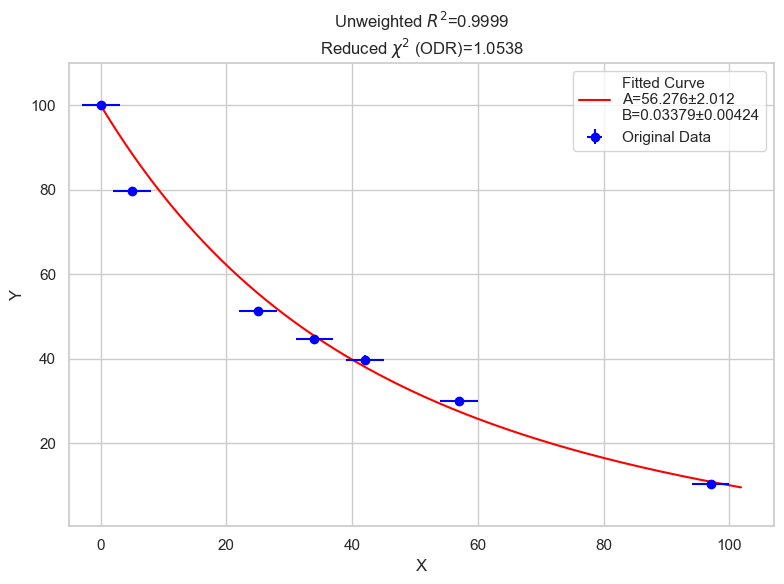

In [14]:
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    Note: The signature is now (beta, x) for scipy.odr.
    """

    A_1 = 56.769
    B_1 = 0.00988

    A, B = beta
    
    return A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100

# Dataset 1
x = np.array([0, 5, 25, 34, 42, 57, 97])
y_obs = np.array([100, 79.7, 51.3, 44.6, 39.8, 29.9, 10.3])

# Dataset 2
# x = np.array([0, 19, 45, 104, 191, 294, 391])
# y_obs = np.array([100, 80.4, 66.4, 50.1, 41.2, 28.5, 20.1])
sigma_y = np.full_like(y_obs, 1.0, dtype=float)
sigma_x = np.full_like(x, 3.0, dtype=float)
initial_guess = [50, 0.01]

# Analyze the curve fit and get results using ODR
odr_results = analyze_odr(x, y_obs, sigma_x, sigma_y, model_function, initial_guess)

# Print the metrics
print_metrics(odr_results)

# Draw the curve fit plot
draw_curve_fit(odr_results, model_function)

## Code 4

=== ORTHOGONAL DISTANCE REGRESSION (ODR) ANALYSIS ===
X uncertainties (sigma_x): 2.0
Y uncertainties (sigma_y): 0.5
=== ODR CURVE FIT ANALYSIS ===

--- ODR Output Information ---
ODR Info Code: 1
ODR Stopping Reason: ['Sum of squares convergence']

--- Fitted Parameters ---
Parameter A: 56.76943 +/- 0.42674
  T-value: 133.02996178, P-value: 0.00000000
Parameter B: 0.00988 +/- 0.00026
  T-value: 37.44078054, P-value: 0.00000026

--- Model Fit Statistics ---
Number of Observations (n): 7
Number of Parameters (p): 2
Degrees of Freedom (n-p): 5
Condition Number: 7.0425e+06

--- ODR Specific Metrics ---
Sum of Squares (S_min) from ODR: 3.766549
Sum of Squared Delta (residuals): 1.487060
Sum of Squared Epsilon (y-residuals): 2.279489

--- Chi-Squared Comparison ---
Chi-Squared (ODR): 3.766549
Chi-Squared (Manual): 35.203831
Reduced Chi-Squared (ODR): 0.753310
Reduced Chi-Squared (Manual): 7.040766

--- Goodness-of-Fit Metrics (Y-direction) ---
Unweighted R-squared: 0.9993
Weighted R-squared:

<Figure size 1200x800 with 0 Axes>

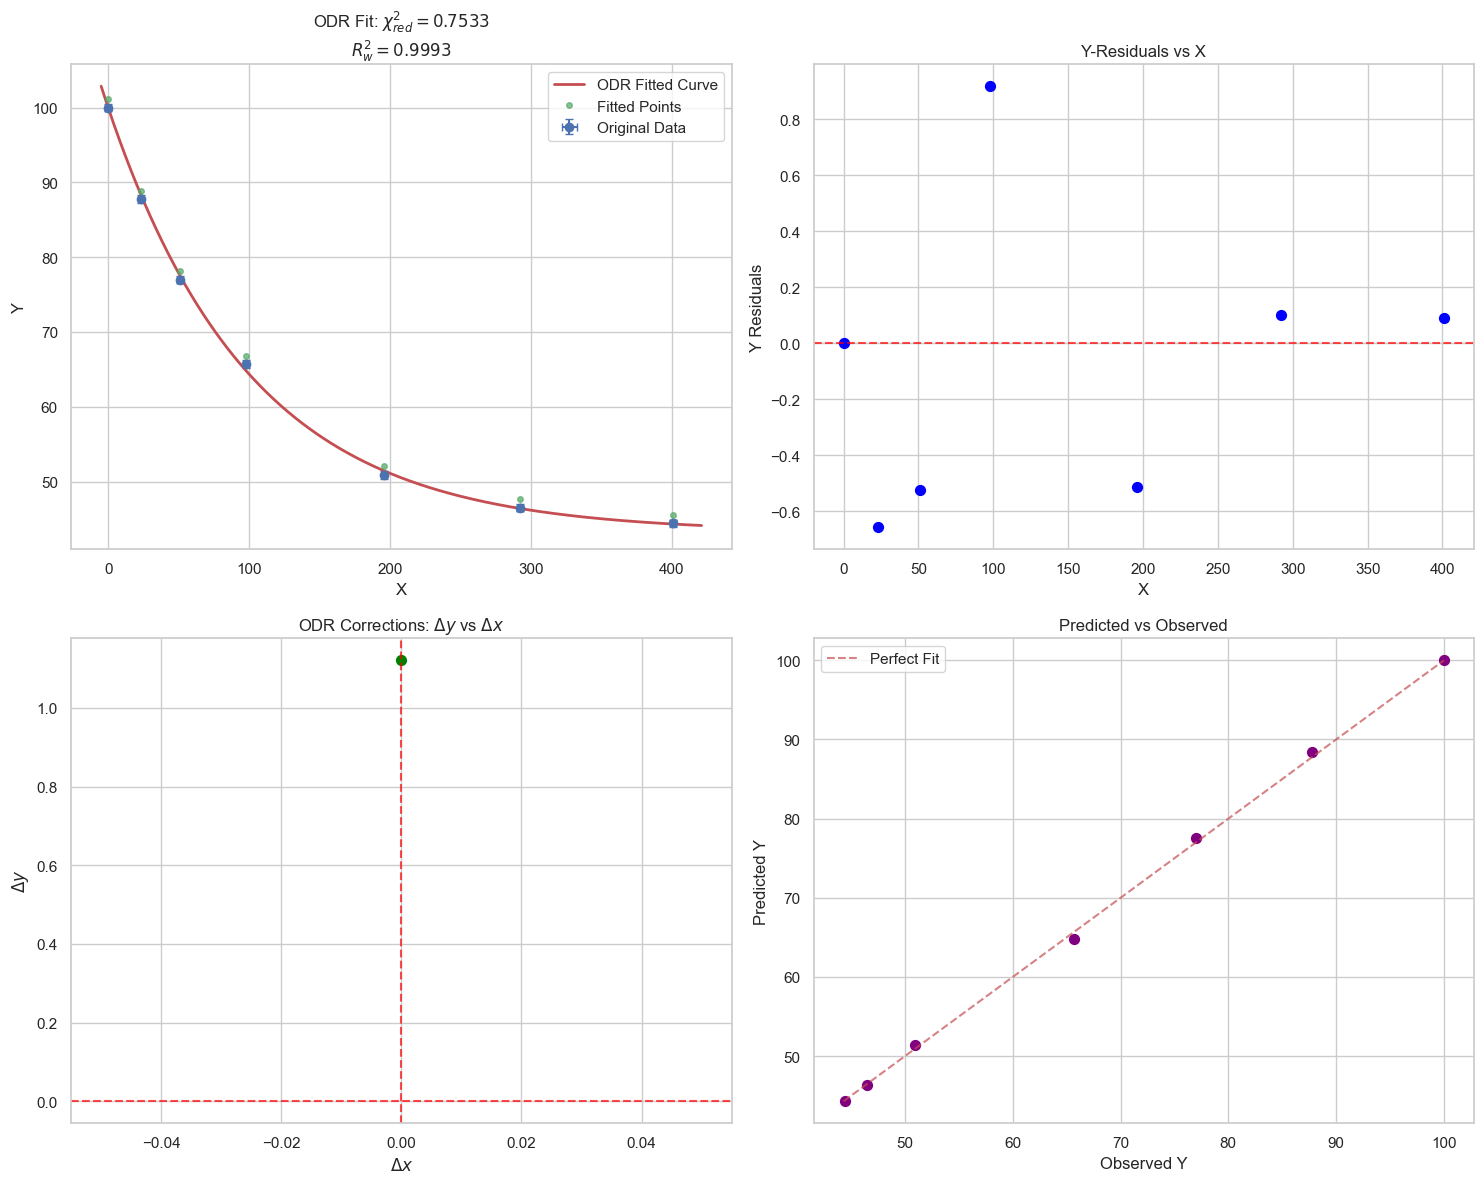

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import odr
import seaborn as sns
import scipy.stats as stats


def analyze_curve_fit_odr(x, y_obs, sigma_x, sigma_y, function, initial_guess):
    """
    Performs an Orthogonal Distance Regression (ODR) curve fit and calculates various
    goodness-of-fit and error metrics.

    Args:
        x (np.array): The independent variable data.
        y_obs (np.array): The observed dependent variable data.
        sigma_x (np.array): The standard deviations of the x points.
        sigma_y (np.array): The standard deviations of the y_obs points.
        function (callable): The function to fit to the data (must accept beta, x format).
        initial_guess (list): The initial guess for the function parameters.

    Returns:
        dict: A dictionary containing all the calculated results.
    """
    results = {}

    results['x_data'] = x
    results['y_data'] = y_obs
    results['sigma_x'] = sigma_x
    results['sigma_y'] = sigma_y

    # Create ODR model
    model = odr.Model(function)
    data = odr.RealData(x, y_obs, sx=sigma_x, sy=sigma_y)
    odr_obj = odr.ODR(data, model, beta0=initial_guess)
    
    # Perform the ODR fit
    output = odr_obj.run()
    
    # Store ODR output information
    results['odr_output'] = output
    results['popt'] = output.beta
    results['pcov'] = output.cov_beta
    
    # Extract key ODR results
    results['fit_params'] = output.beta
    results['std_errs'] = output.sd_beta
    results['sum_square'] = output.sum_square  # This is the objective function value (S_min)
    results['sum_square_delta'] = output.sum_square_delta  # Sum of squared delta (residuals in both x and y)
    results['sum_square_eps'] = output.sum_square_eps  # Sum of squared epsilon (residuals in y only)
    
    # Basic statistics
    n = len(x)
    p = len(initial_guess)
    degrees_of_freedom = n - p
    
    results['number_of_observations'] = n
    results['number_of_parameters'] = p
    results['degrees_of_freedom'] = degrees_of_freedom
    results['condition_number'] = np.linalg.cond(output.cov_beta) if output.cov_beta is not None else np.inf
    
    # Calculate t-values and p-values for parameters
    if output.sd_beta is not None:
        t_values = output.beta / output.sd_beta
        p_values = stats.t.sf(np.abs(t_values), df=degrees_of_freedom) * 2
    else:
        t_values = np.full_like(output.beta, np.nan)
        p_values = np.full_like(output.beta, np.nan)
    
    results['t_values'] = t_values
    results['p_values'] = p_values
    
    # Get fitted values and residuals
    y_pred = function(output.beta, x)
    results['y_pred'] = y_pred
    
    # Calculate residuals in y-direction
    y_residuals = y_obs - y_pred
    results['y_residuals'] = y_residuals
    
    # For ODR, we also have delta values (corrections to x and y)
    if hasattr(output, 'delta'):
        results['delta'] = output.delta  # [delta_x, delta_y]
        results['delta_x'] = output.delta[0] if output.delta is not None else np.zeros_like(x)
        results['delta_y'] = output.delta[1] if output.delta is not None else y_residuals
    else:
        results['delta_x'] = np.zeros_like(x)
        results['delta_y'] = y_residuals
    
    # Calculate fitted x values (x + delta_x)
    x_fitted = x + results['delta_x']
    y_fitted = y_obs + results['delta_y']
    results['x_fitted'] = x_fitted
    results['y_fitted'] = y_fitted
    
    # --- Manual Chi-Squared Calculations ---
    # Manual calculation using the ODR formula
    chi_squared_manual = np.sum((results['delta_x']**2)/(sigma_x**2) + (results['delta_y']**2)/(sigma_y**2))
    reduced_chi_squared_manual = chi_squared_manual / degrees_of_freedom
    
    # ODR provides sum_square which should be equivalent to chi_squared
    chi_squared_odr = output.sum_square
    reduced_chi_squared_odr = chi_squared_odr / degrees_of_freedom
    
    results['chi_squared_manual'] = chi_squared_manual
    results['reduced_chi_squared_manual'] = reduced_chi_squared_manual
    results['chi_squared_odr'] = chi_squared_odr
    results['reduced_chi_squared_odr'] = reduced_chi_squared_odr
    
    # --- Sum of Squares Calculations ---
    # For ODR, traditional R-squared is not as meaningful, but we can calculate variants
    
    # Unweighted versions
    unweighted_mean_y = np.mean(y_obs)
    tss_unweighted = np.sum((y_obs - unweighted_mean_y)**2)
    rss_unweighted = np.sum(y_residuals**2)
    ess_unweighted = np.sum((y_pred - unweighted_mean_y)**2)
    
    # Weighted versions (using y uncertainties)
    weights_y = 1.0 / (sigma_y**2)
    weighted_mean_y = np.sum(weights_y * y_obs) / np.sum(weights_y)
    tss_weighted = np.sum(weights_y * (y_obs - weighted_mean_y)**2)
    rss_weighted = np.sum(weights_y * y_residuals**2)
    ess_weighted = np.sum(weights_y * (y_pred - weighted_mean_y)**2)
    
    results['unweighted_mean_y'] = unweighted_mean_y
    results['weighted_mean_y'] = weighted_mean_y
    results['tss_unweighted'] = tss_unweighted
    results['rss_unweighted'] = rss_unweighted
    results['ess_unweighted'] = ess_unweighted
    results['tss_weighted'] = tss_weighted
    results['rss_weighted'] = rss_weighted
    results['ess_weighted'] = ess_weighted
    
    # R-squared calculations (with caveats for ODR)
    r_squared_unweighted = 1 - rss_unweighted / tss_unweighted
    r_squared_weighted = 1 - rss_weighted / tss_weighted
    
    # Adjusted R-squared
    r_squared_adj_unweighted = 1 - (1 - r_squared_unweighted) * ((n - 1) / (n - p))
    r_squared_adj_weighted = 1 - (1 - r_squared_weighted) * ((n - 1) / (n - p))
    
    results['r_squared_unweighted'] = r_squared_unweighted
    results['r_squared_weighted'] = r_squared_weighted
    results['r_squared_adj_unweighted'] = r_squared_adj_unweighted
    results['r_squared_adj_weighted'] = r_squared_adj_weighted
    
    # --- Error Metrics ---
    rmse_unweighted = np.sqrt(rss_unweighted / n)
    rmse_weighted = np.sqrt(rss_weighted / np.sum(weights_y))
    
    # Standard Error of Regression
    ser_unweighted = np.sqrt(rss_unweighted / degrees_of_freedom)
    ser_weighted = np.sqrt(rss_weighted / degrees_of_freedom)
    
    results['rmse_unweighted'] = rmse_unweighted
    results['rmse_weighted'] = rmse_weighted
    results['ser_unweighted'] = ser_unweighted
    results['ser_weighted'] = ser_weighted
    
    # --- Information Criteria ---
    # For ODR with known uncertainties, log-likelihood calculation
    # Using the chi-squared value in the likelihood
    llf = -0.5 * chi_squared_odr - 0.5 * n * np.log(2 * np.pi) - np.sum(np.log(sigma_x)) - np.sum(np.log(sigma_y))
    
    aic = -2 * llf + 2 * p
    bic = -2 * llf + np.log(n) * p
    aicc = aic + (2 * p * (p + 1)) / (n - p - 1) if n > p + 1 else np.inf
    
    results['log_likelihood'] = llf
    results['aic'] = aic
    results['bic'] = bic
    results['aicc'] = aicc
    
    return results


def print_metrics_odr(results):
    """
    Prints the calculated metrics from the ODR results dictionary.
    
    Args:
        results (dict): The dictionary containing ODR curve fit results.
    """
    fit_params = results['fit_params']
    std_errs = results['std_errs']
    t_values = results['t_values']
    p_values = results['p_values']
    n = results['number_of_observations']
    p = results['number_of_parameters']
    odr_output = results['odr_output']

    print("=== ODR CURVE FIT ANALYSIS ===")
    print("\n--- ODR Output Information ---")
    print(f"ODR Info Code: {odr_output.info}")
    print(f"ODR Stopping Reason: {odr_output.stopreason}")
    
    print("\n--- Fitted Parameters ---")
    for i, (param, err) in enumerate(zip(fit_params, std_errs)):
        print(f"Parameter {chr(ord('A') + i)}: {param:.5f} +/- {err:.5f}")
        print(f"  T-value: {t_values[i]:.8f}, P-value: {p_values[i]:.8f}")

    print("\n--- Model Fit Statistics ---")
    print(f"Number of Observations (n): {n}")
    print(f"Number of Parameters (p): {p}")
    print(f"Degrees of Freedom (n-p): {results['degrees_of_freedom']}")
    print(f"Condition Number: {results['condition_number']:.4e}")

    print("\n--- ODR Specific Metrics ---")
    print(f"Sum of Squares (S_min) from ODR: {results['sum_square']:.6f}")
    print(f"Sum of Squared Delta (residuals): {results['sum_square_delta']:.6f}")
    print(f"Sum of Squared Epsilon (y-residuals): {results['sum_square_eps']:.6f}")

    print("\n--- Chi-Squared Comparison ---")
    print(f"Chi-Squared (ODR): {results['chi_squared_odr']:.6f}")
    print(f"Chi-Squared (Manual): {results['chi_squared_manual']:.6f}")
    print(f"Reduced Chi-Squared (ODR): {results['reduced_chi_squared_odr']:.6f}")
    print(f"Reduced Chi-Squared (Manual): {results['reduced_chi_squared_manual']:.6f}")

    print("\n--- Goodness-of-Fit Metrics (Y-direction) ---")
    print(f"Unweighted R-squared: {results['r_squared_unweighted']:.4f}")
    print(f"Weighted R-squared: {results['r_squared_weighted']:.4f}")
    print(f"Unweighted Adjusted R-squared: {results['r_squared_adj_unweighted']:.4f}")
    print(f"Weighted Adjusted R-squared: {results['r_squared_adj_weighted']:.4f}")

    print("\n--- Error Metrics ---")
    print(f"Unweighted RMSE: {results['rmse_unweighted']:.4f}")
    print(f"Weighted RMSE: {results['rmse_weighted']:.4f}")
    print(f"Unweighted SER: {results['ser_unweighted']:.4f}")
    print(f"Weighted SER: {results['ser_weighted']:.4f}")

    print("\n--- Sum of Squares ---")
    print(f"Unweighted RSS: {results['rss_unweighted']:.4f}")
    print(f"Weighted RSS: {results['rss_weighted']:.4f}")
    print(f"Unweighted ESS: {results['ess_unweighted']:.4f}")
    print(f"Weighted ESS: {results['ess_weighted']:.4f}")
    print(f"Unweighted TSS: {results['tss_unweighted']:.4f}")
    print(f"Weighted TSS: {results['tss_weighted']:.4f}")

    print("\n--- Information Criteria ---")
    print(f"Maximum Log-Likelihood: {results['log_likelihood']:.4f}")
    print(f"AIC (Akaike Information Criterion): {results['aic']:.4f}")
    print(f"BIC (Bayesian Information Criterion): {results['bic']:.4f}")
    print(f"AICc (Corrected AIC): {results['aicc']:.4f}")


def draw_curve_fit_odr(results, model_function):
    """
    Visualizes the original data and the fitted curve from ODR analysis.
    
    Args:
        results (dict): The dictionary containing ODR curve fit results.
        model_function (callable): The model function used for fitting.
    """
    plt.figure(figsize=(12, 8))
    sns.set_theme(style="whitegrid")

    x_data = results["x_data"]
    y_data = results["y_data"]
    sigma_x = results["sigma_x"]
    sigma_y = results["sigma_y"]
    popt = results['fit_params']
    perr = results['std_errs']
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Data with error bars and fitted curve
    ax1.errorbar(x_data, y_data, xerr=sigma_x, yerr=sigma_y, fmt='bo', 
                label="Original Data", capsize=3, capthick=1, markersize=6)
    
    # Generate points for the fitted curve
    x_plot = np.linspace(min(x_data) - 5, max(x_data) * 1.05, 500)
    y_plot = model_function(popt, x_plot)
    
    ax1.plot(x_plot, y_plot, 'r-', linewidth=2, label='ODR Fitted Curve')
    
    # Show corrected points
    x_fitted = results['x_fitted']
    y_fitted = results['y_fitted']
    ax1.plot(x_fitted, y_fitted, 'go', markersize=4, label='Fitted Points', alpha=0.7)
    
    # Draw lines showing corrections
    for i in range(len(x_data)):
        ax1.plot([x_data[i], x_fitted[i]], [y_data[i], y_fitted[i]], 'g--', alpha=0.5, linewidth=1)
    
    title1 = (f"ODR Fit: $\\chi^2_{{red}}={results['reduced_chi_squared_odr']:.4f}$\n"
              f"$R^2_{{w}}={results['r_squared_weighted']:.4f}$")
    ax1.set_title(title1)
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Residuals in Y direction
    y_residuals = results['y_residuals']
    ax2.scatter(x_data, y_residuals, color='blue', s=50)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax2.set_title("Y-Residuals vs X")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y Residuals")
    ax2.grid(True)
    
    # Plot 3: Delta corrections
    delta_x = results['delta_x']
    delta_y = results['delta_y']
    ax3.scatter(delta_x, delta_y, color='green', s=50)
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax3.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    ax3.set_title("ODR Corrections: $\\Delta y$ vs $\\Delta x$")
    ax3.set_xlabel("$\\Delta x$")
    ax3.set_ylabel("$\\Delta y$")
    ax3.grid(True)
    
    # Plot 4: Predicted vs Observed
    y_pred = results['y_pred']
    ax4.scatter(y_data, y_pred, color='purple', s=50)
    min_val = min(min(y_data), min(y_pred))
    max_val = max(max(y_data), max(y_pred))
    ax4.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect Fit')
    ax4.set_title("Predicted vs Observed")
    ax4.set_xlabel("Observed Y")
    ax4.set_ylabel("Predicted Y")
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()


# ODR model function (note: different parameter order than curve_fit)
def odr_model_function(beta, x):
    """
    The custom function for ODR fitting.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    
    Args:
        beta: array of parameters [A, B]
        x: independent variable
    """
    A, B = beta
    return A * (np.exp(-B * x) - 1) + 100


# Original model function for plotting
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    """
    A, B = beta
    return A * (np.exp(-B * x) - 1) + 100


# Dataset 3 with ODR analysis
x = np.array([0, 23, 51, 98, 196, 292, 401])
y_obs = np.array([100, 87.8, 77, 65.7, 50.9, 46.5, 44.4])
sigma_x = np.full_like(x, 2.0, dtype=float)  # X uncertainties = 2.0
sigma_y = np.full_like(y_obs, 0.5, dtype=float)  # Y uncertainties = 0.5
initial_guess = [50, 0.01]

print("=== ORTHOGONAL DISTANCE REGRESSION (ODR) ANALYSIS ===")
print(f"X uncertainties (sigma_x): {sigma_x[0]}")
print(f"Y uncertainties (sigma_y): {sigma_y[0]}")

# Analyze the curve fit using ODR and get results
fit_results_odr = analyze_curve_fit_odr(x, y_obs, sigma_x, sigma_y, odr_model_function, initial_guess)

# Print the metrics
print_metrics_odr(fit_results_odr)

# Draw the curve fit plot
draw_curve_fit_odr(fit_results_odr, model_function)

In [16]:
# ODR model function (note: different parameter order than curve_fit)
def odr_model_function(beta, x):
    """
    The custom function for ODR fitting.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    
    Args:
        beta: array of parameters [A, B]
        x: independent variable
    """
    A_1 = 56.769
    B_1 = 0.00988

    A, B = beta
    
    return A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100


# Original model function for plotting
def model_function(beta, x):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    """
    A_1 = 56.769
    B_1 = 0.00988

    A, B = beta
    
    return A_1 * (np.exp(-B_1 * x) - 1) + A * (np.exp(-B * x) - 1) + 100

=== ORTHOGONAL DISTANCE REGRESSION (ODR) ANALYSIS ===
X uncertainties (sigma_x): 2.0
Y uncertainties (sigma_y): 0.5
=== ODR CURVE FIT ANALYSIS ===

--- ODR Output Information ---
ODR Info Code: 1
ODR Stopping Reason: ['Sum of squares convergence']

--- Fitted Parameters ---
Parameter A: 56.48375 +/- 1.85220
  T-value: 30.49542373, P-value: 0.00000071
Parameter B: 0.03340 +/- 0.00404
  T-value: 8.26408960, P-value: 0.00042316

--- Model Fit Statistics ---
Number of Observations (n): 7
Number of Parameters (p): 2
Degrees of Freedom (n-p): 5
Condition Number: 6.7078e+05

--- ODR Specific Metrics ---
Sum of Squares (S_min) from ODR: 12.485325
Sum of Squared Delta (residuals): 11.624443
Sum of Squared Epsilon (y-residuals): 0.860882

--- Chi-Squared Comparison ---
Chi-Squared (ODR): 12.485325
Chi-Squared (Manual): 529.367893
Reduced Chi-Squared (ODR): 2.497065
Reduced Chi-Squared (Manual): 105.873579

--- Goodness-of-Fit Metrics (Y-direction) ---
Unweighted R-squared: 0.9806
Weighted R-squa

<Figure size 1200x800 with 0 Axes>

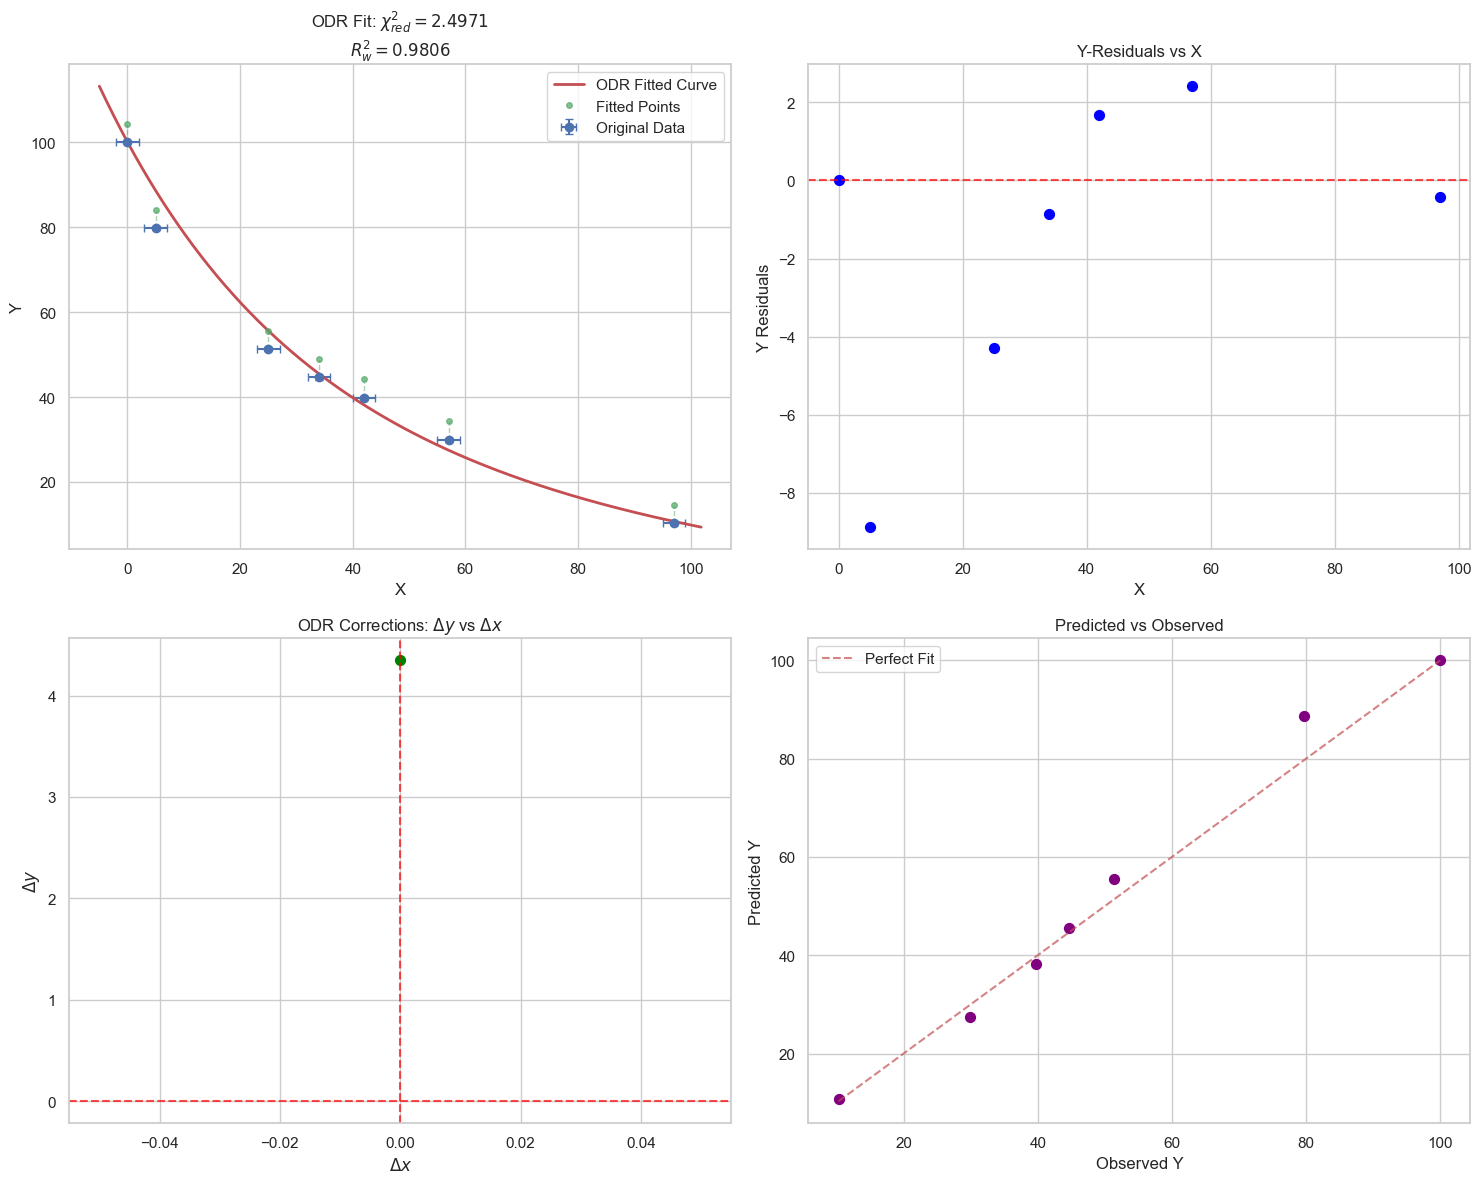

In [17]:
# Dataset 1
x = np.array([0, 5, 25, 34, 42, 57, 97])
y_obs = np.array([100, 79.7, 51.3, 44.6, 39.8, 29.9, 10.3])
sigma_x = np.full_like(x, 2.0, dtype=float)  # X uncertainties = 2.0
sigma_y = np.full_like(y_obs, 0.5, dtype=float)  # Y uncertainties = 0.5
initial_guess = [50, 0.01]

print("=== ORTHOGONAL DISTANCE REGRESSION (ODR) ANALYSIS ===")
print(f"X uncertainties (sigma_x): {sigma_x[0]}")
print(f"Y uncertainties (sigma_y): {sigma_y[0]}")

# Analyze the curve fit using ODR and get results
fit_results_odr = analyze_curve_fit_odr(x, y_obs, sigma_x, sigma_y, odr_model_function, initial_guess)

# Print the metrics
print_metrics_odr(fit_results_odr)

# Draw the curve fit plot
draw_curve_fit_odr(fit_results_odr, model_function)